<a href="https://colab.research.google.com/github/rh2098ta/Practicalapplication3/blob/main/practical3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


df = pd.read_csv("bank-additional-full.csv", sep=";")

# Target to 0/1
df["y"] = (df["y"].str.lower() == "yes").astype(int)

df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [ ]:
print(df.shape)
print(df["y"].value_counts(normalize=True))
df.isna().mean().sort_values(ascending=False).head(10)


(41188, 21)
y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


,0
age,0.0
job,0.0
marital,0.0
education,0.0
default,0.0
housing,0.0
loan,0.0
contact,0.0
month,0.0
day_of_week,0.0


In [ ]:
X = df.drop(columns=["y"])
y = df["y"].values

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


In [ ]:
df_small = (df.groupby("y", group_keys=False)
              .apply(lambda g: g.sample(min(len(g), 3000), random_state=42),
                     include_groups=False)
              .reset_index(drop=True))



In [ ]:
models = {
    "KNN (k=15)": KNeighborsClassifier(n_neighbors=15),
    "Logistic Regression": LogisticRegression(max_iter=300, solver="lbfgs"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=42),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
}

rows = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess),
                          ("model", model)])
    cv_results = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
    rows.append({
        "Model": name,
        "Accuracy": cv_results["test_accuracy"].mean(),
        "Precision": cv_results["test_precision"].mean(),
        "Recall": cv_results["test_recall"].mean(),
        "F1": cv_results["test_f1"].mean(),
        "ROC_AUC": cv_results["test_roc_auc"].mean(),
    })

results = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
results


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.875167,0.867290,0.886000,0.876475,0.941327
1,SVM (RBF),0.885667,0.856734,0.926333,0.890143,0.941015
2,KNN (k=15),0.848000,0.852479,0.841667,0.847011,0.920435
3,Decision Tree,0.837167,0.838205,0.836000,0.836947,0.837167


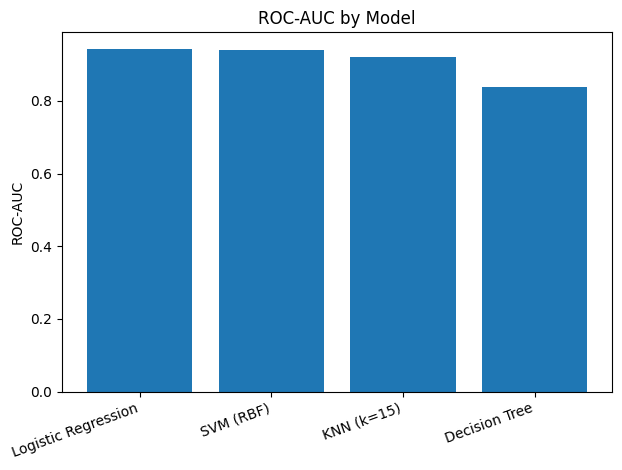

In [ ]:
plt.figure()
plt.bar(results["Model"], results["ROC_AUC"])
plt.title("ROC-AUC by Model")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()